In [22]:
'''Import packages'''
'''Requires numpy, pandas, scikit-learn, and matplotlib/seaborn'''
import numpy as np
import pandas as pd
from skbio.stats import composition
#from sklearn.feature_selection import f_regression
#from sklearn.feature_selection import mutual_info_regression
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_predict
#from sklearn.linear_model import Lasso
from scipy.stats import kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")
import itertools

'''Import script which contains functions'''
import analysis_functions
#from analysis_functions import get_r2
#from analysis_functions import get_lassoCV
#from analysis_functions import perform_randomizedLasso

from IPython.display import display, HTML

#If we want to time the implementation: 
#import time
#start_time = time.time()

In [23]:
'''Import data'''
data_abs = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/1in3/muskegon/muskegon_absolute_otu_1in3.tsv', sep=' ', index_col=None, header=0, float_precision='high')
data_rel = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/1in3/muskegon/muskegon_relative_otu_1in3.tsv', sep=' ', index_col=None, header=0, float_precision='high')
target = pd.read_csv('data/Chloroplasts_removed/ByLake_Filtering/1in3/muskegon/muskegon_sampledata_1in3.tsv', sep= ' ', index_col=0, header=0)
productivity = pd.read_table('data/Chloroplasts_removed/productivity_data_v2.tsv', index_col=0, header=0)

In [24]:
'''Set sample names as index and shuffle data'''
index = target.Lake[target.Lake == 'Muskegon'].index

#Remove outlier samples:
data_abs = data_abs.loc[index,:] 
data_rel = data_rel.loc[index,:]
target = target.loc[index,:]
productivity = productivity.loc[index,:]

#Shuffle data: 
#data_abs = data_abs.sample(frac=1, random_state=3)
#data_rel = data_rel.sample(frac=1, random_state=3)
#target = target.sample(frac=1, random_state=3)
#productivity = productivity.sample(frac=1, random_state=3) 

#Create target columns of HNA-values: 
hna = target.loc[:,'HNA.cells']
hna_rel = hna/target.loc[:,'Total.cells']
hna = pd.Series(hna, index=hna.index)
hna_rel = pd.Series(hna_rel, index=hna.index)

#Create target columns of LNA-values: 
lna = target.loc[:,'LNA.cells']
lna_rel = lna/target.loc[:,'Total.cells']
lna = pd.Series(lna, index=lna.index)
lna_rel = pd.Series(lna_rel, index=lna.index)

In [43]:
hna_scores = pd.read_csv('Final/hnascores_otus_1seq3_clr_Muskegon.csv', index_col=0)

''' Log-Ratio analyses '''
otus = list(data_rel.columns)
data_rel_repl = composition.multiplicative_replacement(data_rel.loc[:,otus])
data_rel_clr = pd.DataFrame(composition.clr(data_rel_repl), columns=otus, index=index)

In [44]:
tot_bacprod = productivity.loc[:,'tot_bacprod'].dropna()
index_prod = tot_bacprod[tot_bacprod.values < 90].index
prod = productivity.loc[index_prod,'tot_bacprod']

In [45]:
kendall_abs = np.zeros(hna_scores.shape[0])
p_kendall_abs = np.zeros(hna_scores.shape[0])
kendall_rel = np.zeros(hna_scores.shape[0])
p_kendall_rel = np.zeros(hna_scores.shape[0])
kendall_clr = np.zeros(hna_scores.shape[0])
p_kendall_clr = np.zeros(hna_scores.shape[0])

i=0
for otu in hna_scores.index:
    kendall_abs[i], p_kendall_abs[i] = kendalltau(data_abs.loc[index_prod,otu],prod)
    kendall_rel[i], p_kendall_rel[i] = kendalltau(data_rel.loc[index_prod,otu],prod)
    kendall_clr[i], p_kendall_clr[i] = kendalltau(data_rel_clr.loc[index_prod,otu],prod)
    i+=1
    
hna_scores['kendall_prod_abs'] = kendall_abs
hna_scores['p_kendall_prod_abs'] = p_kendall_abs
hna_scores['kendall_prod_rel'] = kendall_rel
hna_scores['p_kendall_prod_rel'] = p_kendall_rel
hna_scores['kendall_prod_clr'] = kendall_clr
hna_scores['p_kendall_prod_clr'] = p_kendall_clr

In [46]:
display(hna_scores.head(14))

,score,abun_abs_mean,abun_abs_CV,abun_rel_mean,abun_rel_CV,kendall,p_kendall,kendall_prod_abs,p_kendall_prod_abs,kendall_prod_rel,p_kendall_prod_rel,kendall_prod_clr,p_kendall_prod_clr
Otu000173,0.348,17982.674014,1.283752,0.002493,1.133719,0.555791,1.726790e-10,0.294737,0.069236,0.287250,0.079141,0.242105,0.135585
Otu000271,0.302,11451.572755,1.573856,0.001448,1.328281,0.322052,2.163519e-04,0.344839,0.034604,0.331593,0.043525,0.326316,0.044268
Otu004486,0.232,4.194974,7.874008,0.000003,7.874008,-0.077737,3.719161e-01,NaN,NaN,NaN,NaN,-0.242105,0.135585
Otu000409,0.230,901.523111,2.513040,0.000276,2.860081,-0.364357,2.851129e-05,0.274315,0.148178,0.274315,0.148178,-0.073684,0.649671
Otu001663,0.220,149.332153,3.612738,0.000021,3.603783,0.066103,4.476969e-01,NaN,NaN,NaN,NaN,-0.242105,0.135585
Otu000274,0.212,284.552149,5.283941,0.000024,4.839270,0.022739,7.939494e-01,0.282941,0.140458,0.282941,0.140458,-0.094737,0.559222
Otu000058,0.206,34517.294498,1.428403,0.008396,1.958523,-0.325225,1.872977e-04,0.105263,0.516412,-0.016177,0.922038,-0.021053,0.896743
Otu003756,0.204,12.394288,7.874008,0.000007,7.874008,-0.079852,3.590450e-01,NaN,NaN,NaN,NaN,-0.242105,0.135585
Otu000778,0.198,2095.823803,2.161501,0.000259,1.661020,0.210999,1.536927e-02,0.284994,0.092754,0.247015,0.160701,0.200000,0.217619
Otu001503,0.194,255.934766,2.946415,0.000062,2.446513,-0.318879,2.495987e-04,-0.335664,0.073406,-0.335664,0.073406,-0.410526,0.011385


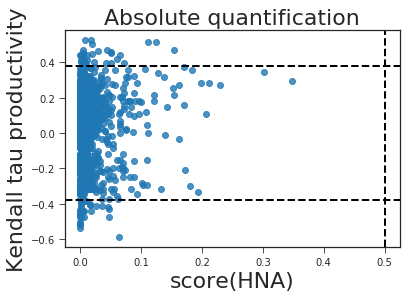

In [47]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_abs'], fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Absolute quantification', size=22)
plt.show()

In [48]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_abs'] > 0.377)].index

In [49]:
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_abs.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Absolute abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

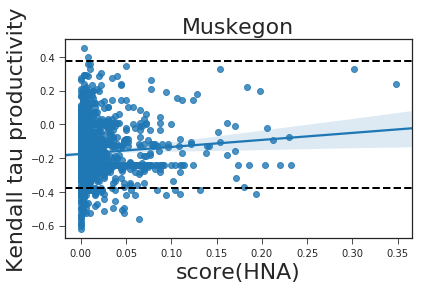

In [62]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_clr'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Muskegon', size=22)
plt.tight_layout()
plt.savefig('Muskegon_kendallprod_HNA.png', dpi=500)
plt.show()

In [51]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_clr'] > 0.377)].index
palette = itertools.cycle(sns.color_palette())
for otu in otus_prod: 
    plt.figure()
    sns.regplot(x=data_rel.loc[index_prod,otu],y=prod,label=otu, color=next(palette), fit_reg=True)
    plt.xlabel('Relative abundance', size=22)
    plt.xticks(size=10)
    plt.ylabel('Productivity', size=22)
    plt.yticks(size=10)
    plt.legend()
    plt.show()
    i+=1

In [52]:
otus_prod = hna_scores[(hna_scores.loc[:,'score'] > 0.5) & (hna_scores.loc[:,'kendall_prod_rel'] > 0.377)].index

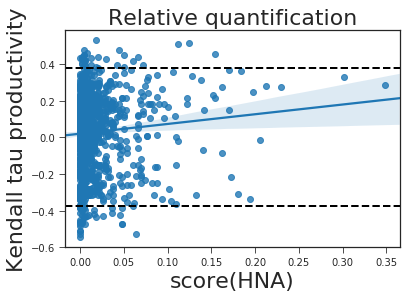

In [53]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=hna_scores.loc[:,'kendall_prod_rel'])
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Relative quantification', size=22)
plt.show()

In [54]:
kendall_sum_abs = np.zeros(hna_scores.shape[0])
p_kendall_sum_abs = np.zeros(hna_scores.shape[0])
kendall_sum_rel = np.zeros(hna_scores.shape[0])
p_kendall_sum_rel = np.zeros(hna_scores.shape[0])
kendall_sum_clr = np.zeros(hna_scores.shape[0])
p_kendall_sum_clr = np.zeros(hna_scores.shape[0])
kendall_sum_clr_thr = np.zeros(hna_scores.shape[0])
p_kendall_sum_clr_thr = np.zeros(hna_scores.shape[0])

sum_abs = np.zeros(len(index_prod))
sum_rel = np.zeros(len(index_prod))
sum_clr = np.zeros(len(index_prod))
sum_clr_thr = np.zeros(len(index_prod))

i=0
thr = 0
for otu in hna_scores.index:
    sum_abs += data_abs.loc[index_prod,otu]
    sum_rel += data_rel.loc[index_prod,otu]
    sum_clr += data_rel_clr.loc[index_prod,otu]
    sum_clr_thr += data_rel_clr.loc[index_prod,otu]
    kendall_sum_abs[i], p_kendall_sum_abs[i] = kendalltau(sum_abs,prod)
    kendall_sum_rel[i], p_kendall_sum_rel[i] = kendalltau(sum_rel,prod)
    kendall_sum_clr[i], p_kendall_sum_clr[i] = kendalltau(sum_clr,prod)
    kendall_sum_clr_thr[i], p_kendall_sum_clr_thr[i] = kendalltau(sum_clr_thr,prod)
    if kendall_sum_clr_thr[i] > thr: 
        thr = kendall_sum_clr_thr[i]
    else: 
        sum_clr_thr -= data_rel_clr.loc[index_prod,otu]
        kendall_sum_clr_thr[i] = 0
    i+=1

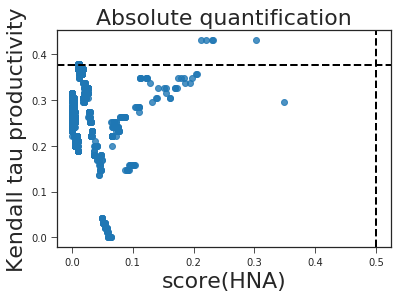

In [55]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_abs,fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Absolute quantification', size=22)
plt.show()

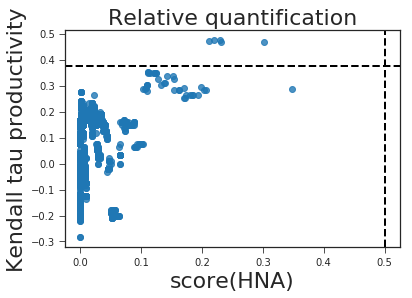

In [56]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_rel, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Relative quantification', size=22)
plt.show()

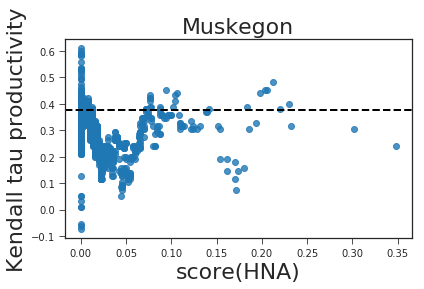

In [63]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_clr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('Muskegon', size=22)
plt.tight_layout()
plt.savefig('Muskegon_kendallprod_sum_HNA.png', dpi=500)
plt.show()

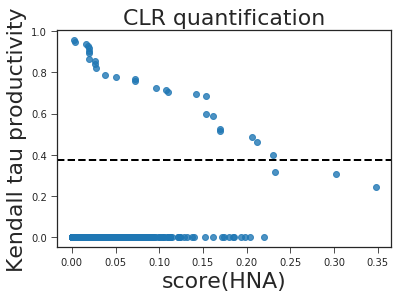

In [58]:
plt.figure()
sns.regplot(x=hna_scores.loc[:,'score'],y=kendall_sum_clr_thr, fit_reg=False)
plt.xlabel('score(HNA)', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR quantification', size=22)
plt.show()

In [59]:
otus_prod = hna_scores.loc[kendall_sum_clr_thr > 0,:].index
print('OTUs part of productivity correlation pool:' + str(otus_prod))

OTUs part of productivity correlation pool:Index(['Otu000173', 'Otu000271', 'Otu004486', 'Otu000409', 'Otu000274',
       'Otu000058', 'Otu000329', 'Otu001661', 'Otu002947', 'Otu003366',
       'Otu000614', 'Otu001584', 'Otu004993', 'Otu001637', 'Otu002680',
       'Otu001027', 'Otu000993', 'Otu000390', 'Otu000543', 'Otu010342',
       'Otu001157', 'Otu002752', 'Otu001568', 'Otu001086', 'Otu001350',
       'Otu004850', 'Otu003316', 'Otu002834', 'Otu000025', 'Otu000096'],
      dtype='object')


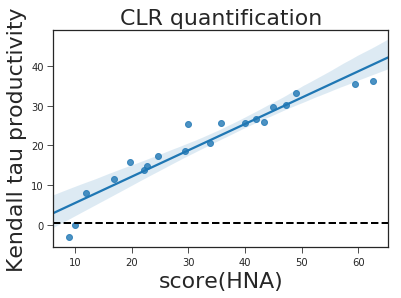

In [60]:
plt.figure()
sns.regplot(x=prod,y=sum_clr_thr, fit_reg=True)
plt.xlabel('Productivity', size=22)
plt.xticks(size=10)
plt.ylabel('Kendall tau productivity', size=22)
plt.yticks(size=10)
plt.axhline(y=0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axhline(y=-0.377, linewidth=2, linestyle='--', color = 'k')
#plt.axvline(x=0.5, linewidth=2, linestyle='--', color = 'k')
plt.title('CLR quantification', size=22)
plt.show()